In [1]:
# Imports
from collections import defaultdict, Counter, deque
from functools import lru_cache, reduce, cmp_to_key
from intervaltree import IntervalTree
import itertools
import json
import math
import networkx as nx
import numpy as np
import numpy.typing as npt
import re
from sortedcontainers import SortedList
import time
from typing import Callable, TypeVar, Union, Optional


T = TypeVar('T')

# Helper functions

def data(day: int, parser: Callable[[str], T] = str) -> list[T]:
  with open(f"./data/day{day}.txt") as f:
    return [parser(line.strip()) for line in f.readlines()]

def split_csv_row(row: str) -> list[int]:
  return [int(x) for x in row.split(',')]

def split_int_row(row: str) -> list[int]:
  return [int(x) for x in row]

In [299]:
a = True
if (b := a) and True:
  print(b)

True


# Day 1

In [300]:
def parse_day1(data):
  elves = SortedList()
  current = 0
  for food in data:
    if not food:
      elves.add(current)
      current = 0
    else:
      current += int(food)
  return elves

data1 = parse_day1(data(1))

In [301]:
data1[-1]

71780

In [302]:
sum(data1[-3:])

212489

# Day 2

In [303]:
def parse2(data):
  result = Counter()
  for round in data:
    result[round] += 1
  return result
data2 = parse2(data(2))

In [304]:
score = {
  'A X': 3 + 1, # Rock Rock
  'A Y': 6 + 2, # Rock Paper
  'A Z': 0 + 3, # Rock Scissor
  'B X': 0 + 1, # Paper Rock
  'B Y': 3 + 2, # Paper Paper
  'B Z': 6 + 3, # Paper Scissor
  'C X': 6 + 1, # Scissor Rock
  'C Y': 0 + 2, # Scissor Paper
  'C Z': 3 + 3, # Scissor Scissor
}
sum([score[x]*data2[x] for x in data2])

13924

In [305]:
score = {
  'A X': 0 + 3, # Rock Lose Sciss
  'A Y': 3 + 1, # Rock Draw Rock
  'A Z': 6 + 2, # Rock Win Paper
  'B X': 0 + 1, # Paper Lose Rock
  'B Y': 3 + 2, # Paper Draw Paper
  'B Z': 6 + 3, # Paper Win Sciss
  'C X': 0 + 2, # Scissor Lose Paper
  'C Y': 3 + 3, # Scissor Draw Sciss
  'C Z': 6 + 1, # Scissor Win Rock
}
sum([score[x]*data2[x] for x in data2])

13448

# Day 3

In [306]:
data3 = data(3)

def item_priority(item):
  if ord(item) > 96:
    return ord(item) - 96
  return ord(item) - 38

In [307]:
def rucksack_items(rucksack):
  length = len(rucksack)//2
  return rucksack[:length], rucksack[length:]
  
def day3(data):
  sum = 0
  for x in data:
    a, b = rucksack_items(x)
    sum += item_priority(list(set(a).intersection(set(b)))[0])
  return sum

day3(data3)

7727

In [308]:
def day3_2(data):
  sum = 0
  for i in range(len(data)//3):
    a, b, c = data[i*3:i*3+3]
    common = set(a).intersection(set(b)).intersection(set(c))
    sum += item_priority(list(common)[0])
  return sum

day3_2(data3)

2609

# Day 4

In [309]:
data4 = data(4)

In [310]:
def has_envelop(a, b):
  return a[0] <= b[0] and a[1] >= b[1]

def day4(data, f):
  count = 0
  for i in data:
    a, b = [[int(x) for x in elf.split('-')] for elf in i.split(',')]
    count += f(a, b) or f(b, a)
  return count

day4(data4, has_envelop)

602

In [311]:
def has_overlap(a, b):
  return (a[0] <= b[0] and a[1] >= b[0]) or (a[0] >= b[0] and a[0] <= b[1])

day4(data4, has_overlap)

891

# Day 5

In [312]:
def make_move(positions, count, start, end):
  if count == 0:
    return
  item = positions[start].popleft()
  positions[end].appendleft(item)
  return make_move(positions, count-1, start, end)

def read_top(positions):
  return ''.join([positions[i][0] for i in range(len(positions))])

def day5(make_move):
  def parse5():
    with open('./data/day5.txt') as f:
      lines = f.readlines()
    positions = defaultdict(lambda: deque())
    line_length = len(lines[0])
    for n, line in enumerate(lines):
      for i in range(line_length//4):
        item = line[i*4:i*4+4].strip()
        if item == '1':
          return positions, lines[n+2:]
        if item:
          positions[i].append(re.match('\[([A-Z])\]', item)[1])
  positions, moves = parse5()
  for turn in moves:
    result = re.match('move (\d+) from (\d) to (\d)', turn)
    make_move(positions, int(result[1]), int(result[2])-1, int(result[3])-1)
  return read_top(positions)

day5(make_move)

'RFFFWBPNS'

In [313]:
def make_move_9001(positions, count, start, end):
  stack = deque()
  for _ in range(count):
    stack.appendleft(positions[start].popleft())
  positions[end].extendleft(stack)

day5(make_move_9001)

'CQQBBJFCS'

# Day 6

In [314]:
data6 = data(6)[0]

In [315]:
def day6(n):
  for i in range(len(data6)-n+1):
    if len(set(data6[i:i+n])) == n:
      return i + n

day6(4), day6(14)

(1262, 3444)

# Day 7

In [316]:
class Dir:
  def __init__(self, parent=None):
    self.parent = parent
    self.files = 0
    self.children = {}

def ls(item, cwd):
  if item.startswith('dir'):
    cwd.children[item[4:]] = Dir(cwd)
  else:
    cwd.files += int(item.split(' ')[0]) 

def cd(cmd, cwd, root):
  if cmd.startswith('cd'):
    cwd = root if cmd == 'cd /' else cwd.parent if '..' in cmd else cwd.children[cmd.split(' ')[1]]
  return cwd

def parse7(data):
  root = Dir()
  cwd = root
  for line in data:
    if line[0] == '$':
      cwd = cd(line[2:], cwd, root)
    else:
      ls(line, cwd)
  return root

data7 = []
def calculate_total_sizes(root):
  total = root.files
  for child in root.children:
    total += calculate_total_sizes(root.children[child])
  data7.append(total)
  return total
total = calculate_total_sizes(parse7(data(7)))

In [317]:
sum([x for x in data7 if x <= 100000])

1206825

In [318]:
target = total - (70000000 - 30000000)
next(filter(lambda x: x >= target, sorted(data7)))

9608311

# Day 8

In [319]:
data8 = np.array(data(8, lambda x: [int(n) for n in x]))
y, x = data8.shape

In [320]:
maskn, masks = [np.full([1, x], True)[0]], []
for i in range(x-1):
  forward = np.amax(data8[:i+1], 0)
  maskn.append(data8[i+1] > forward)
  backward = np.amax(data8[i+1:], 0)
  masks.append(data8[i] > backward)
masks.append(np.full([1, x], True)[0])

maskw, maske =  [np.full([y, 1], True)[:, 0]], []
for i in range(y-1):
  forward = np.amax(data8[:, :i+1], 1)
  maskw.append(data8[:, i+1] > forward)
  backward = np.amax(data8[:, i+1:], 1)
  maske.append(data8[:, i] > backward)
maske.append(np.full([y, 1], True)[:, 0])

mask = np.vstack(maskn) | np.vstack(masks) | np.vstack(maskw).transpose() | np.vstack(maske).transpose()
len(data8[np.where(mask)])

1816

In [321]:
def directional_score(geni, genj, axis=0):
  score = [np.zeros([1, x])[0]]
  for i in geni:
    current = data8[i] if axis == 0 else data8[:, i]
    visible = np.full([1, x], True)[0]
    result = np.zeros([1, x])[0]
    for j in genj(i):
      candidate = data8[j] if axis == 0 else data8[:, j]
      result += np.ones([1, x])[0] * visible
      visible = (current > candidate) & visible
    score.append(result)
  return np.vstack(score)

north = directional_score(range(1, x), lambda i: range(i-1, -1, -1))
south = np.flip(directional_score(range(x-2, -1, -1), lambda i: range(i+1, x)), 0)
west = directional_score(range(1, x), lambda i: range(i-1, -1, -1), 1).transpose()
east = np.flip(directional_score(range(x-2, -1, -1), lambda i: range(i+1, x), 1).transpose(), 1)
int(np.max(north * south * east * west))

383520

# Day 9

In [322]:
data9 = data(9, lambda x: x.split(' '))

In [323]:
def day9(data, knots=2):
  visited = set()
  state = [(0,0)] * knots

  def move_head(x, y, direction):
    match direction:
      case 'R':
        x += 1
      case 'L':
        x -= 1
      case 'U':
        y += 1
      case 'D':
        y -= 1
    return (x, y)

  def move_tail(headx, heady, tailx, taily):
    if abs(headx - tailx) > 1 and abs(heady - taily) > 1:
      return (headx + (1 if tailx > headx else -1), heady + (1 if taily > heady else -1))
    if abs(headx - tailx) > 1:
      return (headx + (1 if tailx > headx else -1), heady)
    if abs(heady - taily) > 1:
      return (headx, heady + (1 if taily > heady else -1))
    return (tailx, taily)

  def make_move(current, direction, count):
    for _ in range(count):
      current[0] = move_head(*current[0], direction)
      for i in range(1, len(current)):
        current[i] = move_tail(*current[i-1], *current[i])
      visited.add(current[-1])
    return current

  for move in data:
    state = make_move(state, move[0], int(move[1]))

  return len(visited)

day9(data9), day9(data9, 10)

(6181, 2386)

# Day 10

In [324]:
def parse10(data):
  q, i, state, op = deque([0]), 0, 1, 0

  def tock(i, state, op):
    if not op:
      if q:
        op = q.popleft()
    else:
      state += op
      op = 0
    i += 1
    return i, state, op

  for command in data:
    q.append(0 if len(command) == 1 else int(command[1]))
    i, state, op = tock(i, state, op)
    yield state
  while q:
    i, state, op = tock(i, state, op)
    yield state
  i, state, op = tock(i, state, op)
  yield state

data10 = lambda: parse10((data(10, lambda x: x.split(' '))))

In [325]:
def day10_1(data):
  signal = 0
  targets = [20, 60, 100, 140, 180, 220]
  for i, v in enumerate(data):
    if i+1 in targets:
      signal += (i+1) * v
  return signal
day10_1(data10())

14420

In [326]:
def day10_2(data):
  image = ''
  for i, v in enumerate(data):
    position, sprite = i+1, v
    if position%40 in range(sprite, sprite+3):
      image += '#'
    else:
      image += ' '
    if not position%40:
      image += '\n'
  return image
print(day10_2(data10()))

###   ##  #    ###  ###  ####  ##  #  # 
#  # #  # #    #  # #  #    # #  # #  ##
#  # #    #    #  # ###    #  #  # #  # 
###  # ## #    ###  #  #  #   #### #  ##
# #  #  # #    # #  #  # #    #  # #  ##
#  #  ### #### #  # ###  #### #  #  ##  
  


# Day 11

In [327]:
# Hardcoded
example = [
  lambda x: x*19,
  lambda x: x+6,
  lambda x: x*x,
  lambda x: x+3
]
actual = [ 
  lambda x: x*13,
  lambda x: x+2,
  lambda x: x+6,
  lambda x: x*x,
  lambda x: x+3,
  lambda x: x*7,
  lambda x: x+4,
  lambda x: x+7
]
data11 = (data(11), actual)

In [328]:
def parse11(data, ops):
  monkeys, divisor = [], 1

  class Monkey:
    def __init__(self, items, op, n, a, b):
      self.items = items
      self.operation = op
      self.n = n
      self.a = a
      self.b = b
      self.count = 0

    def run(self, flag=False):
      t, f = monkeys[self.a], monkeys[self.b]
      for old in self.items:
        new = (self.operation(old) // (1 if flag else 3)) % divisor
        (f if new%self.n else t).items.append(new)
        self.count += 1
      self.items = []

    def __repr__(self):
      return f'{self.count}, {self.items}'

  monkey = {}
  for line in data:
    if not line:
      monkeys.append(Monkey(**monkey))
    if m := re.match('Starting items: ([\d+, ]+)', line):
      monkey['items'] = [int(x) for x in m[1].split(', ')]
    elif m:= re.match('Operation: new = old (.) (.+)', line):
      monkey['op'] = ops[len(monkeys)]
    elif m:= re.match('Test: divisible by (\d+)', line):
      monkey['n'] = int(m[1])
      divisor *= monkey['n']
    elif m:= re.match('If true: throw to monkey (\d)', line):
      monkey['a'] = int(m[1])
    elif m:= re.match('If false: throw to monkey (\d)', line):
      monkey['b'] = int(m[1])
  monkeys.append(Monkey(**monkey))
  return monkeys

def day11(data, rounds, flag=False):
  monkeys = parse11(*data)
  for _ in range(rounds):
    for monkey in monkeys:
      monkey.run(flag)
  activity = sorted(monkeys, key=lambda x: x.count, reverse=True)
  return activity[0].count * activity[1].count

day11(data11, 20)

121450

In [329]:
day11(data11, 10000, True)

28244037010

# Day 12

In [330]:
def remap12(c):
  return 0 if c == 'S' else (25 if c == 'E' else ord(c) - ord('a'))

def parse12(data):
  start, end, result = 0, 0, []
  for i, line in enumerate(data):
    if 'S' in line:
      start = (line.find('S'), i)
    if 'E' in line:
      end = (line.find('E'), i)
    result.append([remap12(c) for c in line])

  x_m, y_m = len(result[0]), len(result)
  def find_routes(current, i):
    x, y = current
    options = filter(lambda x: x[0] >= 0 and x[1] >= 0 and x[0] < x_m and x[1] < y_m, [(x, y+1), (x, y-1), (x+1, y), (x-1, y)])
    target = result[y][x] -1
    return [(coord, i+1) for coord in filter(lambda x: result[x[1]][x[0]] >= target, options)]

  return start, end, find_routes

data12 = data(12)
start, end, find_routes = parse12(data12)

def dijkstra(start, end, route_finder, cache={}):
  visited, q = set([start]), deque(route_finder(start, 0))
  while q:
    current, i = q.popleft()
    if current == end:
      return i
    for option, j in route_finder(current, i):
      if option not in visited:
        q.append((option, j))
        cache[option] = j
      visited.add(option)
  return np.Inf

dijkstra(end, start, find_routes)

339

In [331]:
def find_starts(data):
  starts = []
  for y, line in enumerate(data):
    for x, c in enumerate(line):
      if c == 'a' or c == 'S':
        starts.append((x, y))
  return sorted(starts, key=lambda x: abs(x[0]-end[0]) + abs(x[1]-end[1]), reverse=True)

cache = {}
starts = find_starts(data12)
for start in starts:
  result = dijkstra(end, start, find_routes, cache)
  if result == np.Inf:
    break
min([cache.get(start, np.Inf) for start in starts])

332

# Day 13

In [332]:
def parse13(data):
  current, pairs = None, []
  for line in data:
    if not line:
      continue
    if not isinstance(current, list):
      current = json.loads(line)
    else:
      pairs.append((current, json.loads(line)))
      current = None
  return pairs

data13 = parse13(data(13))

In [333]:
def compare_int(a, b):
  if a == b:
    return 0
  return -1 if a < b else 1

def make_list(item):
  if isinstance(item, list):
    return item
  return [item]

def compare_list(a, b):
  for i in range(min(len(a), len(b))):
    if result := compare(a[i], b[i]):
      return result
  if len(a) == len(b):
    return 0
  return -1 if len(a) < len(b) else 1

def compare(a, b):
  if isinstance(a, list) or isinstance(b, list):
    return compare_list(make_list(a), make_list(b))
  return compare_int(a, b)

def day13(data):
  sum = 0
  for i, pair in enumerate(data):
    if compare(*pair) == -1:
      sum += i+1
  return sum

day13(data13)

5366

In [334]:
def day13_2(data):
  dividers = ([[2]], [[6]])
  data = reduce(lambda x, y: x+list(y), data13 + [dividers], [])
  result = sorted(data, key=cmp_to_key(compare))
  indices = [result.index(x)+1 for x in dividers]
  return indices[0]*indices[1]

day13_2(data13)

23391

# Day 14

In [335]:
def parse14(data):
  results, bottom = set(), 0
  for line in data:
    coordinates = [[int(x) for x in coord.split(',')] for coord in line.split(' -> ')]
    x1, y1 = coordinates[0]
    for (x2, y2) in coordinates[1:]:
      for i in range(min(x1, x2), max(x1,x2)+1):
        for j in range(min(y1, y2), max(y1,y2)+1):
          results.add((i, j))
      bottom = max(bottom, j)
      x1, y1 = x2, y2
  return results, bottom
  
data14 = parse14(data(14))

In [336]:
def day14(sand, bottom, flag=False):  
  sand, start, initial, path = sand.copy(), (500, 0), len(sand), deque()
  while start not in sand:
    x, y = path.pop() if path else start
    while (x, y) not in sand:
      for candidate in ((x, y+1), (x-1, y+1), (x+1, y+1)):
        if candidate not in sand:
          path.append(candidate)
          x, y = candidate
          break
      if candidate in sand or candidate[1] > bottom:
        sand.add((x, y))
    if not flag and candidate[1] > bottom:
      break
  return len(sand) - initial - (1 if not flag else 0)

day14(*data14), day14(*data14, True)

(1061, 25055)

# Day 15

In [337]:
def parse15(data):
  sensors, beacons = [], []
  for line in data:
    match = re.match('Sensor at x=(-?\d+), y=(-?\d+): closest beacon is at x=(-?\d+), y=(-?\d+)', line)
    sensors.append((int(match[1]), int(match[2])))
    beacons.append((int(match[3]), int(match[4])))
  return sensors, beacons

data15 = parse15(data(15))

def scan_depth(sensors, beacons, target=2000000):
  tree = IntervalTree()
  for sensor, beacon in zip(sensors, beacons):
    distance = int(abs(sensor[0]-beacon[0]) + abs(sensor[1] - beacon[1]))
    if (remaining := distance - abs(target - sensor[1])) > 0:
      tree.addi(sensor[0] - remaining, sensor[0] + remaining + 1.01)
  tree.merge_overlaps()
  return tree

In [338]:
def day15_1(data, target=2000000):
  tree = scan_depth(*data, target)
  return int(tree.end() - tree.begin()) - 1

day15_1(data15)

5564017

In [339]:
def day15_2(data, target=4000000):
  tree = IntervalTree()
  tree.addi(-target, target+1)

  for i in range(target+1):
    result = scan_depth(*data, i)
    if len(result) > 1:
      return int(min([x.end for x in list(result)])) * 4000000 + i

# Takes a couple minutes - should use 45 degree rotation instead
day15_2(data15)

KeyboardInterrupt: 

# Day 16

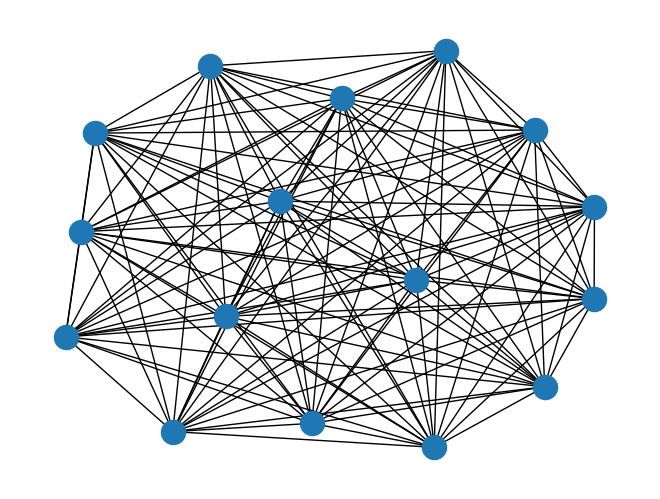

In [ ]:
def parse16(data):
  G = nx.Graph()
  for line in data:
    match = re.match('Valve (.+) has flow rate=(\d+); tunnels? leads? to valves? (.+)', line)
    node, flow, neighbors = match[1], int(match[2]), match[3].split(', ')
    G.add_node(node, weight=flow)
    for neighbor in neighbors:
      G.add_edge(node, neighbor)

  result = nx.Graph()
  weighted_nodes = set([x for x in G.nodes if G.nodes[x]['weight']])
  for node, paths in nx.all_pairs_shortest_path_length(G, cutoff=30):
    if node in weighted_nodes or node == 'AA':
      result.add_node(node, weight=G.nodes[node]['weight'])
      for neighbor in paths:
        if neighbor != node and neighbor in weighted_nodes:
          result.add_edge(node, neighbor, length=paths[neighbor]+1)
  
  return result

data16 = parse16(data(16))
nx.draw(data16)

In [ ]:
def day16_1(G, t):
  @lru_cache()
  def traverse(current, t, visited):
    neighbors = G[current]
    pressure = sum([G.nodes[x]['weight'] for x in visited]) + G.nodes[current]['weight']

    score = t * pressure
    for neighbor in neighbors:
      length = neighbors[neighbor]['length']
      if neighbor not in visited and (tminus := t - length) > 0:
        result = traverse(neighbor, tminus, frozenset(visited | set([current]))) + length * pressure
        score = max(result, score)
    return score
  return traverse('AA', t, frozenset())

day16_1(data16, 30)

1880

In [ ]:
def all_combinations(any_list):
    return itertools.chain.from_iterable(
        itertools.combinations(any_list, i + 1)
        for i in range(1, math.floor(len(any_list)/2)))

def remap_edges(G, child):
  child.add_node('AA', weight=0)
  for a, b in itertools.combinations(child.nodes, 2):
    child.add_edge(a, b, length=G[a][b]['length'])
  return child

def generate_partition(combination, G):
  a, b = nx.Graph(), nx.Graph()
  for i in G.nodes:
    (a if i in combination else b).add_node(i, weight=G.nodes[i]['weight'])
  return remap_edges(G, a), remap_edges(G, b)
    
# Takes a couple minutes - should speed up partition generation (maybe with https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.kernighan_lin.kernighan_lin_bisection.html)
def day16_2(G):
  result = 0
  combinations = all_combinations(set(G.nodes).difference(set(['AA'])))
  for combination in combinations:
    a, b = generate_partition(set(combination), G)
    result = max(result, day16_1(a, 26) + day16_1(b, 26))
  return result

day16_2(data16)

2520

# Day 17

In [ ]:
data17 = [1 if x == '>' else -1 for x in data(17)[0]]

pieces = [
    (frozenset(range(4)),), # -
    (frozenset([1]), frozenset(range(3)), frozenset([1])), # cross
    (frozenset(range(3)), frozenset([2]), frozenset([2])), # L
    (frozenset([0]),)*4,
    (frozenset(range(2)), frozenset(range(2)))
]

class Piece:
  def __init__(self, x, y, base):
    self.x = x
    self.y = y
    self.base = base

  def in_rocks(self, rocks):
    for i, v in enumerate(self.base):
      y = i + self.y
      row = frozenset([self.x + p for p in v])
      if (rocks[y] if y < len(rocks) else frozenset([0, 8])).intersection(row):
        return True
    return False

  def add_to_rocks(self, rocks):
    new_rocks, start = list(rocks), 0
    for i, v in enumerate(self.base):
      y = i + self.y
      row = frozenset([self.x + p for p in v])
      if y < len(rocks):
        new_rocks[y] = rocks[y].union(row)
        start = y if new_rocks[y] == frozenset(range(9)) else start
      else:
        new_rocks.append(frozenset([0, 8]).union(row))
    return tuple(new_rocks)[start:], len(new_rocks) - len(rocks)

  def move_jet(self, jet, rocks):
    self.x += jet
    if self.in_rocks(rocks):
      self.x -= jet

  def move_gravity(self, rocks):
    self.y -= 1
    if self.in_rocks(rocks):
      self.y += 1
      return self.add_to_rocks(rocks)
    return rocks, -1

  def move(self, jet, rocks):
    self.move_jet(jet, rocks)
    return self.move_gravity(rocks)

  def __repr__(self):
    return f'({self.x}, {self.y}) {self.base}'

In [ ]:
def day17(jets, n=2022):
  rocks, j, height = (frozenset(range(9)),), 0, 0

  def move_piece(pi, j, rocks):
    piece = Piece(3, len(rocks)+3, pieces[pi])
    for i in range(0, piece.y):
      ji = (j + i)%len(jets)
      rocks, diff = piece.move(jets[ji], rocks)
      if diff > -1:
        break
    return rocks, diff, (ji+1)%len(jets)

  cache = {}
  for i in range(n):
    args = i%len(pieces), j, rocks
    if cache.get(args):
      cycle_start, cycle_height = cache[args]
      period_length, period_depth = i - cycle_start, height-cycle_height
      iterations = int((n-cycle_start)/period_length)
      i = cycle_start + iterations * period_length
      height = cycle_height + iterations * period_depth
      break
    rocks, diffy, j = move_piece(*args)
    cache[args] = (i, height)
    height += diffy

  for i in range(i, n):
    rocks, diffy, j = move_piece(i%len(pieces), j, rocks)
    height += diffy
  return height


# Take a long time
day17(data17, 2022), day17(data17, 1000000000000)

(3186, 1566376811584)

# Day 18

In [ ]:
data18 = data(18, lambda line: tuple([int(x) for x in line.split(',')]))

In [ ]:
def generate_sides(square):
  x, y, z = square
  return [
    (square, (x+1, y, z+1)),
    (square, (x+1, y+1, z)),
    (square, (x, y+1, z+1)),
    ((x+1, y, z), (x+1, y+1, z+1)),
    ((x, y+1, z), (x+1, y+1, z+1)),
    ((x, y, z+1), (x+1, y+1, z+1)),
  ]

def day18_1(data):
  unique = set()
  joined = set()
  for square in data:
    for side in generate_sides(square):
      if side in joined:
        continue
      elif side in unique:
        unique.remove(side)
        joined.add(side)
      else:
        unique.add(side)
  return unique

len(day18_1(data18))

4314

In [ ]:
def generate_surface_diff(initial, s1, s2):
  # Project from surface out of current cube
  if s1 != s2:
    return 0
  return -1 if initial == s1 else 1

def find_bounds(data):
  start, end = math.inf, 0
  for i in data:
    start, end = min(min(i), start), max(max(i), end)
  return start-1, end+1

def day18_2(data):
  start, end = find_bounds(data)
  uniques, surfaces = day18_1(data), set()

  def route_finder(surface, i):
    x, y, z = surface
    for side in generate_sides(surface):
      if side in uniques:
        surfaces.add(side)
      else:
        (a, b, c), (e, f, g) = side
        result = (
          x + generate_surface_diff(x, a, e),
          y + generate_surface_diff(y, b, f),
          z + generate_surface_diff(z, c, g),
        )
        if not any([x < start or x > end for x in result]):
          yield (result, i+1)

  dijkstra((start, start, start), (end, end, end), route_finder)
  return len(surfaces)

day18_2(data18)

2444

# Day 19

In [359]:
def parse19(line):
  m = re.match('Blueprint (\d+): Each ore robot costs (\d+) ore. Each clay robot costs (\d+) ore. Each obsidian robot costs (\d+) ore and (\d+) clay. Each geode robot costs (\d+) ore and (\d+) obsidian.', line)
  _, ore, clay, ob_ore, ob_clay, ge_ore, ge_ob = m[1], m[2], m[3], m[4], m[5], m[6], m[7]
  return (
    (-int(ore),0,0,0, 1,0,0,0),
    (-int(clay),0,0,0, 0,1,0,0),
    (-int(ob_ore),-int(ob_clay),0,0, 0,0,1,0),
    (-int(ge_ore),0,-int(ge_ob),0, 0,0,0,1),
  )

data19 = data(19, parse19)

def day19(blueprints, flag=False):
  # ore_robot, clay_robot, obsidian_robot, geode_robot, ore, clay, obsidian, geode
  default_state = (0,0,0,0, 1,0,0,0)

  def tuple_add(a, b):
    return tuple(a[i] + (b[i] if i < len(b) else 0) for i in range(len(a)))

  def prune_states(blueprint, state):
    # Assume we will never not build if we can ever build anything we want
    # As a consequence, we will also not build excess robots of a single type
    max_values = [max(-cost[i] for cost in blueprint) for i in range(3)]
    state = (
      *(min(state[i], max_values[i]*2-1) for i in range(3)), 
      state[3],
      *(min(state[i+4], max_values[i]) for i in range(3)), 
      state[7],
    )
    return state

  @lru_cache()
  def robot_potentials(blueprint, state):
    # Can only build one robot per step
    potentials = [state]
    for cost in blueprint:
      potential = tuple_add(state, cost)
      if any(x < 0 for x in potential):
        continue
      potentials.append(potential)
    return [prune_states(blueprint, tuple_add(x, state[4:])) for x in potentials]

  @lru_cache()
  def price_estimate(blueprint, t):
    or_price = -blueprint[0][0]
    cr_price = -blueprint[1][0]
    c_price = int(cr_price/t)
    obr_price = -blueprint[2][1] - blueprint[2][1]*c_price
    ob_price = int(obr_price/t)
    gr_price = max(obr_price, cr_price, or_price, (-blueprint[3][1] - blueprint[3][2]*ob_price)) + 1
    g_price = int(gr_price/t)
    prices = [1, c_price, ob_price, g_price, or_price, cr_price, obr_price, gr_price]
    return prices

  def state_score(state, prices):
    return int(sum(state[i]*prices[i] for i in range(len(state))))

  best = {}
  @lru_cache(maxsize=None)
  def run_robots(blueprint, state, t):
    if t == 0:
      # print(state, state_score(state, price_estimate(blueprint, t+1)))
      return state
    potentials = robot_potentials(blueprint, state)

    prices = price_estimate(blueprint, t)
    sorted_potentials = sorted(zip([state_score(x, prices) for x in potentials], potentials), reverse=True)
    score = sorted_potentials[0][0]

    key = (blueprint, t)
    if (current := best.get(key, 0)) < score:
      best[key] = score
    threshold = current*.95 - 20 # TODO: magic number adjusted until answer is correct
    if score < threshold:
      return default_state

    return max([run_robots(blueprint, option[1], t-1) for option in sorted_potentials if option[0] >= threshold], key=lambda x: x[3])

  def calculate(blueprints, n):
    for i, v in enumerate(blueprints):
      state = run_robots(v, default_state, n)
      # print(i, state, state[3])
      yield state[3]

  def part1():
    sum = 0
    for i, result in enumerate(calculate(blueprints, 24)):
      sum += result * (i+1)
    return sum

  def part2():
    product = 1
    for result in calculate(blueprints[:3], 32):
      product *= result
    return product

  return part2() if flag else part1()

In [360]:
day19(data19)

2193

In [361]:
day19(data19, True)

7200

# Day 20

In [7]:
data20 = data(20, int)

In [11]:
class Node:
  def __init__(self, value, previous=None):
    self.value = value
    self.previous = previous
    self.next = None

  def unset(self):
    self.previous.next = self.next
    self.next.previous = self.previous
    return self
    
  def __repr__(self):
    return f'{self.value}'

def generate_nodes(data, n=1):
  nodes = [Node(i*n) for i in data]
  for i, v in enumerate(nodes):
    v.previous = nodes[i-1]
    v.next = nodes[(i+1)%len(nodes)]
  return nodes

def shift_right(node, value):
  if not value:
    return
  current = node.unset()
  for _ in range(value):
    current = current.next
  current.next.previous = node
  node.next = current.next
  current.next = node
  node.previous = current

def shift_left(node, value):
  if not value:
    return
  current = node.unset()
  for _ in range(value):
    current = current.previous
  current.previous.next = node
  node.previous = current.previous
  current.previous = node
  node.next = current

def mix_nodes(nodes):
  zero = None
  for _, v in enumerate(nodes):
    if not v.value:
      zero = v
      continue
    shift, right = abs(v.value)%(len(nodes)-1), v.value > 0
    (shift_right if right else shift_left)(v, shift)
  return zero
    
def debug_nodes(head):
  current, result = head, []
  while current.next != head:
    result.append(str(current.value))
    current = current.next
  result.append(str(current.value))
  return ', '.join(result)

def get_nth_node(node, n):
  for _ in range(n):
    node = node.next
  return node.value

def day20(data, key=1):
  sum = 0
  nodes = generate_nodes(data, key)
  zero = mix_nodes(nodes)
  if key != 1:
    for i in range(9):
      mix_nodes(nodes)
  for i in [1000, 2000, 3000]:
    sum += get_nth_node(zero, i%len(data))
  return sum

day20(data20), day20(data20, 811589153)

(19559, 912226207972)

# Day 21

In [98]:
def parse21(data):
  monkeys = {}
  for i in data:
    monkeys[i[0]] = int(i[1]) if str.isnumeric(i[1]) else i[1].split(' ')
  return monkeys

data21 = parse21(data(21, lambda x: x.split(': ')))

In [99]:
def mcalculate(monkey, monkeys):
  yell = monkeys[monkey]
  if not isinstance(yell, list):
    return yell
  a, op, b = yell
  expr = f'{mcalculate(a, monkeys)} {op} {mcalculate(b, monkeys)}'
  return eval(expr)

int(mcalculate('root', data21))

160274622817992

In [100]:
from scipy.optimize import minimize_scalar

def day21(monkeys):
  monkeys['root'][1] = '-'

  def loss(humn):
    monkeys['humn'] = humn
    guess = mcalculate('root', monkeys)
    return guess * guess
  
  tol = 1e-6
  while abs(mcalculate('root', monkeys)) >= 0.5:
    tol /= 10
    minimize_scalar(loss, tol=tol)
  return round(monkeys['humn'])

day21(data21.copy())

3087390115721

# Day 22